# Introduction to Gaussian Processes

Welcome! In this notebook, we’ll take a hands-on, intuitive journey into the world of **Gaussian Processes (GPs)**, one of the most elegant and powerful tools in modern machine learning. Whether you’re a data scientist, a researcher, or just curious about how machines can “guess” functions, you’re in the right place.

---

### What’s a Gaussian Process, Anyway?

Imagine you want to predict a function, but you don’t want to commit to a specific form (like a straight line or a polynomial). Instead, you’d like to keep your options open, considering *all possible functions* that fit your data. This is where Gaussian Processes shine: they let us define a **probability distribution over functions**.

Formally, a Gaussian Process is a collection of random variables, any finite number of which have a joint Gaussian (normal) distribution. If we write:

$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$

- $m(x)$ is the mean function (often set to zero for simplicity).
- $k(x, x')$ is the kernel or covariance function, which encodes our assumptions about the function’s smoothness, periodicity, etc.

---

### Why Should You Care?

- **Uncertainty Quantification:** GPs don’t just give you a prediction, they tell you how *confident* they are.
- **Flexibility:** By changing the kernel, you can model everything from smooth trends to wild wiggles.
- **Non-parametric:** No need to choose a fixed number of parameters; the data decides the complexity.

---

### What Will We Do Here?

- Build up the theory behind GPs, step by step.
- See how GPs can be used for regression: making predictions and updating beliefs as new data arrives.
- Visualize how different kernel choices affect our predictions.
- Dive into the math behind the marginal likelihood and how to optimize kernel parameters.
- Annotate the code and formulas so you can connect the theory with practical implementation.

---

Ready? Let’s start by importing the libraries we’ll need and setting up our environment. Along the way, we’ll keep things as clear and approachable as possible—without shying away from the beautiful math that makes GPs tick!

In [ ]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
rc("text", usetex=True)

### Building Our First GP: The Kernel and Prior Samples

Now that our libraries are ready, let’s set up the core ingredients for our Gaussian Process.

By default, we use a **zero mean function** for our GP prior, meaning we assume the average value of the functions is zero unless the data tells us otherwise. This is a common and convenient choice that keeps things simple unless we have prior knowledge suggesting otherwise.

First, we define a **kernel function** (also called a covariance function). The kernel encodes our assumptions about the function we want to model—how smooth it is, how quickly it can change, and so on. Here, we use the Matérn kernel (with $\nu=3/2$), which is a popular choice for its flexibility:

$$
k(x, x') = \sigma^2 \left(1 + \frac{|x - x'|}{\tau}\right) \exp\left(-\frac{|x - x'|}{\tau}\right)
$$

- $\sigma$ controls the overall variance (vertical scale).
- $\tau$ is the length scale (how quickly the function can wiggle).

We then:
- Choose a grid of input points $X$.
- Set up two different length scales (`all_taus = [1, 10]`) to see how the kernel affects the functions.
- For each kernel, we sample random functions from the GP prior (before seeing any data). Each sample is a possible function our GP “believes in” given just the kernel.

This is the first step in understanding GPs: before seeing any data, what kinds of functions do we think are likely? Let’s visualize these samples next!

In [2]:
def kernel(xa, xb, tau=2, sigma=1):
    diff = np.subtract.outer(xa, xb)
    abs_diff = np.abs(diff)
    exp_comp = np.exp(-abs_diff / tau)
    kernel = (sigma**2) * (1 + abs_diff / tau) * exp_comp
    return kernel

all_taus = [1, 10]
sigma = 0.5
n_samps = 20
X = np.linspace(-20, 20, 50)

Sigmas = [kernel(X, X, tau, sigma) for tau in all_taus]
all_samples = [np.random.multivariate_normal(mean=np.zeros(len(X)), cov=Sigma, size=n_samps) for Sigma in Sigmas]

### Visualizing the GP Prior: What Does the Animation Show?

Let’s bring our Gaussian Process prior to life! The animation below shows samples drawn from the GP prior for two different length scales ($\tau = 1$ and $\tau = 10$). Each frame adds a new random function sampled from the prior, illustrating the kinds of functions our GP “believes in” before seeing any data.

- **Left plot:** Shorter length scale ($\tau = 1$) — functions can wiggle quickly and change rapidly.
- **Right plot:** Longer length scale ($\tau = 10$) — functions are much smoother and vary more slowly.

The shaded region marks the range $\mu \pm 2\sigma$, which is where we expect about 95% of the function values to fall, given the prior. Notice how the kernel parameters shape the diversity and smoothness of the sampled functions. This is the power of the kernel: it encodes our assumptions about the functions we expect, even before seeing any data!

MovieWriter ffmpeg unavailable; using Pillow instead.


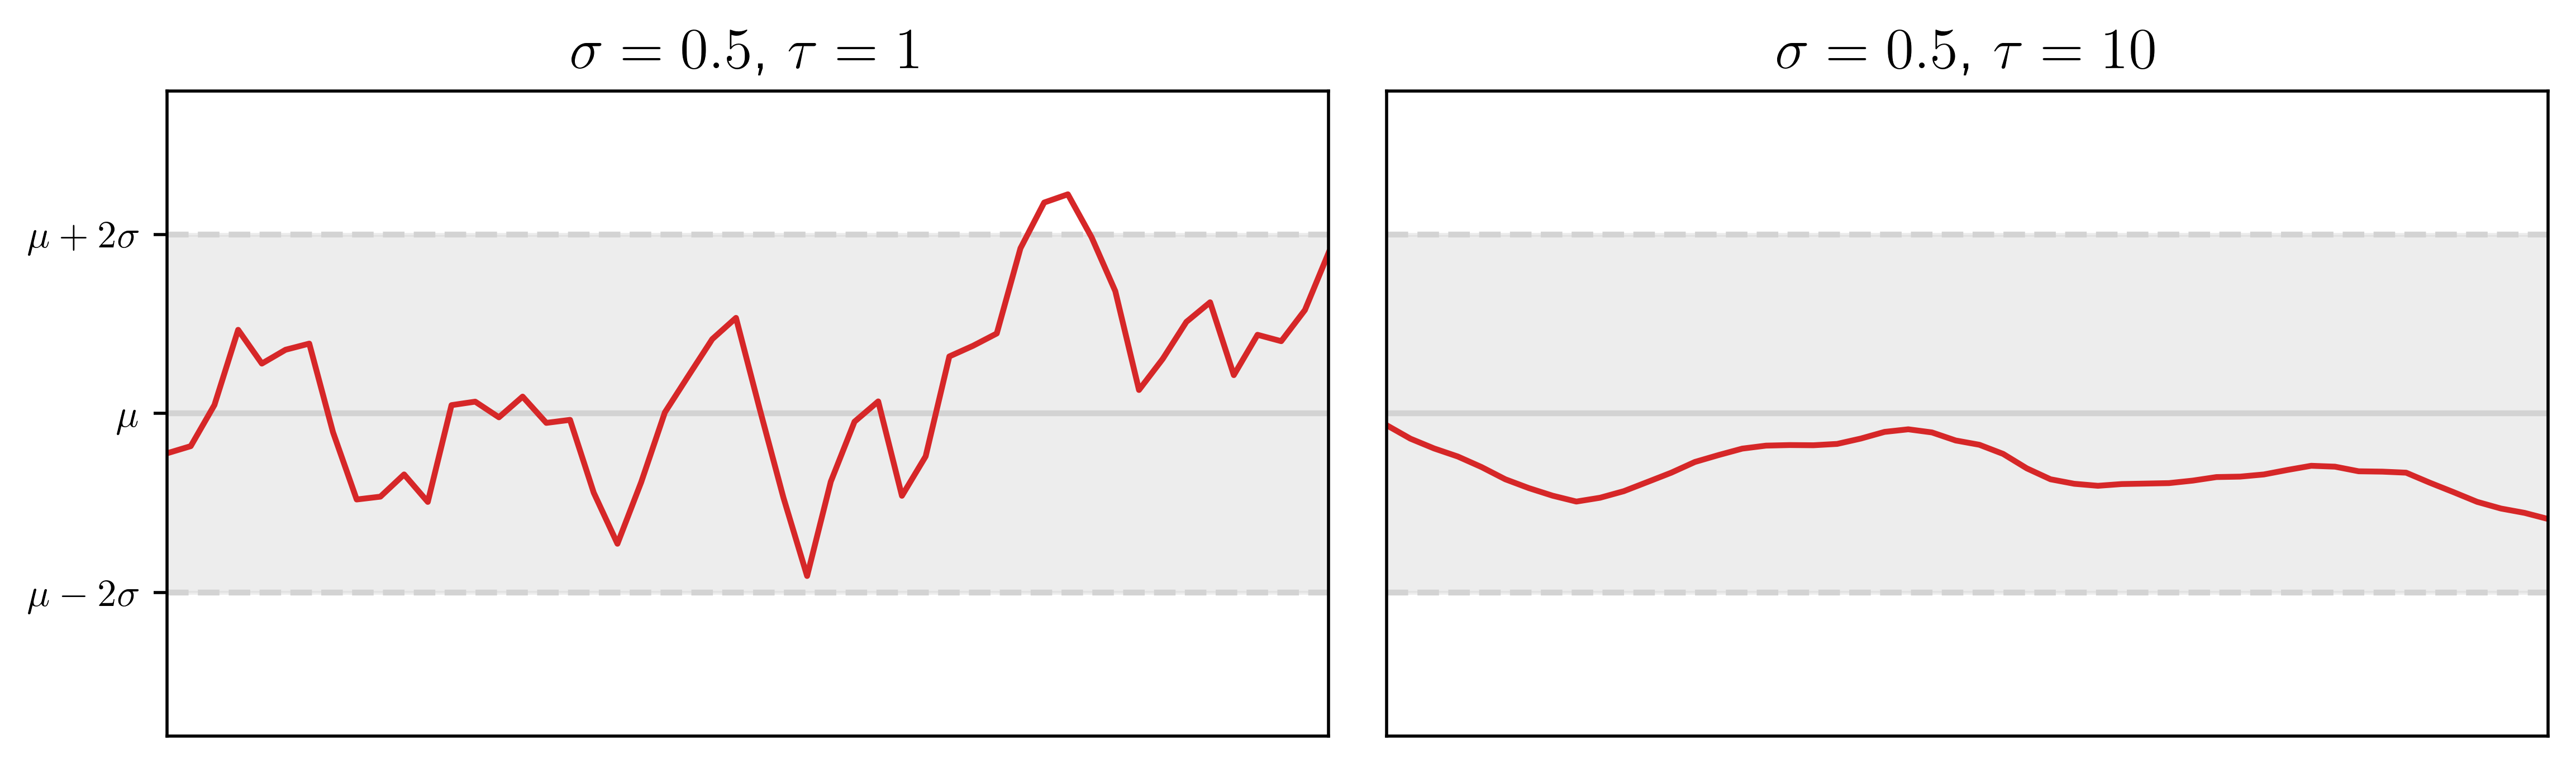

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3), dpi=500)
fig.subplots_adjust(wspace=0.05)
def update(frame):
    for ax, samples, tau in zip(axs, all_samples, all_taus):
        ax.clear()
        ax.set_title(rf"$\sigma=0.5$, $\tau={tau}$", fontsize=15)
        ax.fill_between([-30, 30], 2 * sigma, -2 * sigma, color="lightgray", alpha=0.4)
        ax.axhline(2 * sigma, ls="--", c="lightgray")
        ax.axhline(-2 * sigma, ls="--", c="lightgray")
        ax.axhline(0, c="lightgray")
        ax.plot(X, samples[:frame].T, color="C7", alpha=0.5)
        ax.plot(X, samples[frame].T, color="C3")
        ax.set_xlim(-20, 20)
        ax.set_ylim(-1.8, 1.8)
        ax.set_xticks([])
    axs[0].set_yticks([-2 * sigma, 0, 2 * sigma])
    axs[0].set_yticklabels([r"$\mu - 2\sigma$", r"$\mu$", r"$\mu + 2\sigma$"])
    axs[1].set_yticks([])
ani = animation.FuncAnimation(fig, update, frames=n_samps)
ani.save('../animations/prior.gif', fps=0.8)

### From Prior to Posterior: Conditioning on Data

So far, we’ve seen what kinds of functions our Gaussian Process “believes in” before seeing any data—the prior. But the real magic happens when we condition on observed data points. This is where the GP updates its beliefs and gives us a **posterior distribution** over functions that are consistent with what we’ve observed.

Mathematically, conditioning a GP prior on observed data leads to a new GP—the posterior—with updated mean and covariance:

\begin{align*}
\mu_*(x) &= K(x, X_\text{train}) [K(X_\text{train}, X_\text{train}) + \Sigma_y]^{-1} y_\text{train} \\
\Sigma_*(x, x') &= K(x, x') - K(x, X_\text{train}) [K(X_\text{train}, X_\text{train}) + \Sigma_y]^{-1} K(X_\text{train}, x')
\end{align*}


- $K(X_\text{train}, X_\text{train})$ is the covariance matrix of the training inputs.
- $K(x, X_\text{train})$ is the covariance between test and training points.
- $\Sigma_y$ is the noise covariance (diagonal if noise is independent).
- $y_\text{train}$ are the observed outputs.

The result? The GP now predicts functions that not only fit the data points, but also express uncertainty everywhere else. You’ll see the mean function “bend” to hit the data, and the uncertainty shrink near observations and grow far away.

In the next cells, we’ll compute and visualize the GP posterior for our example data!

In [4]:
def posterior(X_s, X_train, Y_train, tau, sigma, sigma_y=0):
    K = kernel(X_train, X_train, tau, sigma) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, tau, sigma)
    K_ss = kernel(X_s, X_s, tau, sigma) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    return mu_s, cov_s

X_train = np.array([X[i] for i in [10, 23, 35]])
Y_train = np.array([-0.3, 1.1, 0.4])  # + noise * np.random.randn(len(X_train))
Y_train_sigma = np.array([0.1, 0.2, 0.05])

all_posts = [posterior(X, X_train, Y_train, tau, sigma, sigma_y=Y_train_sigma) for tau in all_taus]
all_mus = [all_posts[0][0], all_posts[1][0]]
all_covs = [all_posts[0][1], all_posts[1][1]]
all_samples = [np.random.multivariate_normal(mu.ravel(), cov, n_samps) for mu, cov in zip(all_mus, all_covs)]
all_stds = [np.sqrt(np.diag(cov)) for cov in all_covs]

MovieWriter ffmpeg unavailable; using Pillow instead.


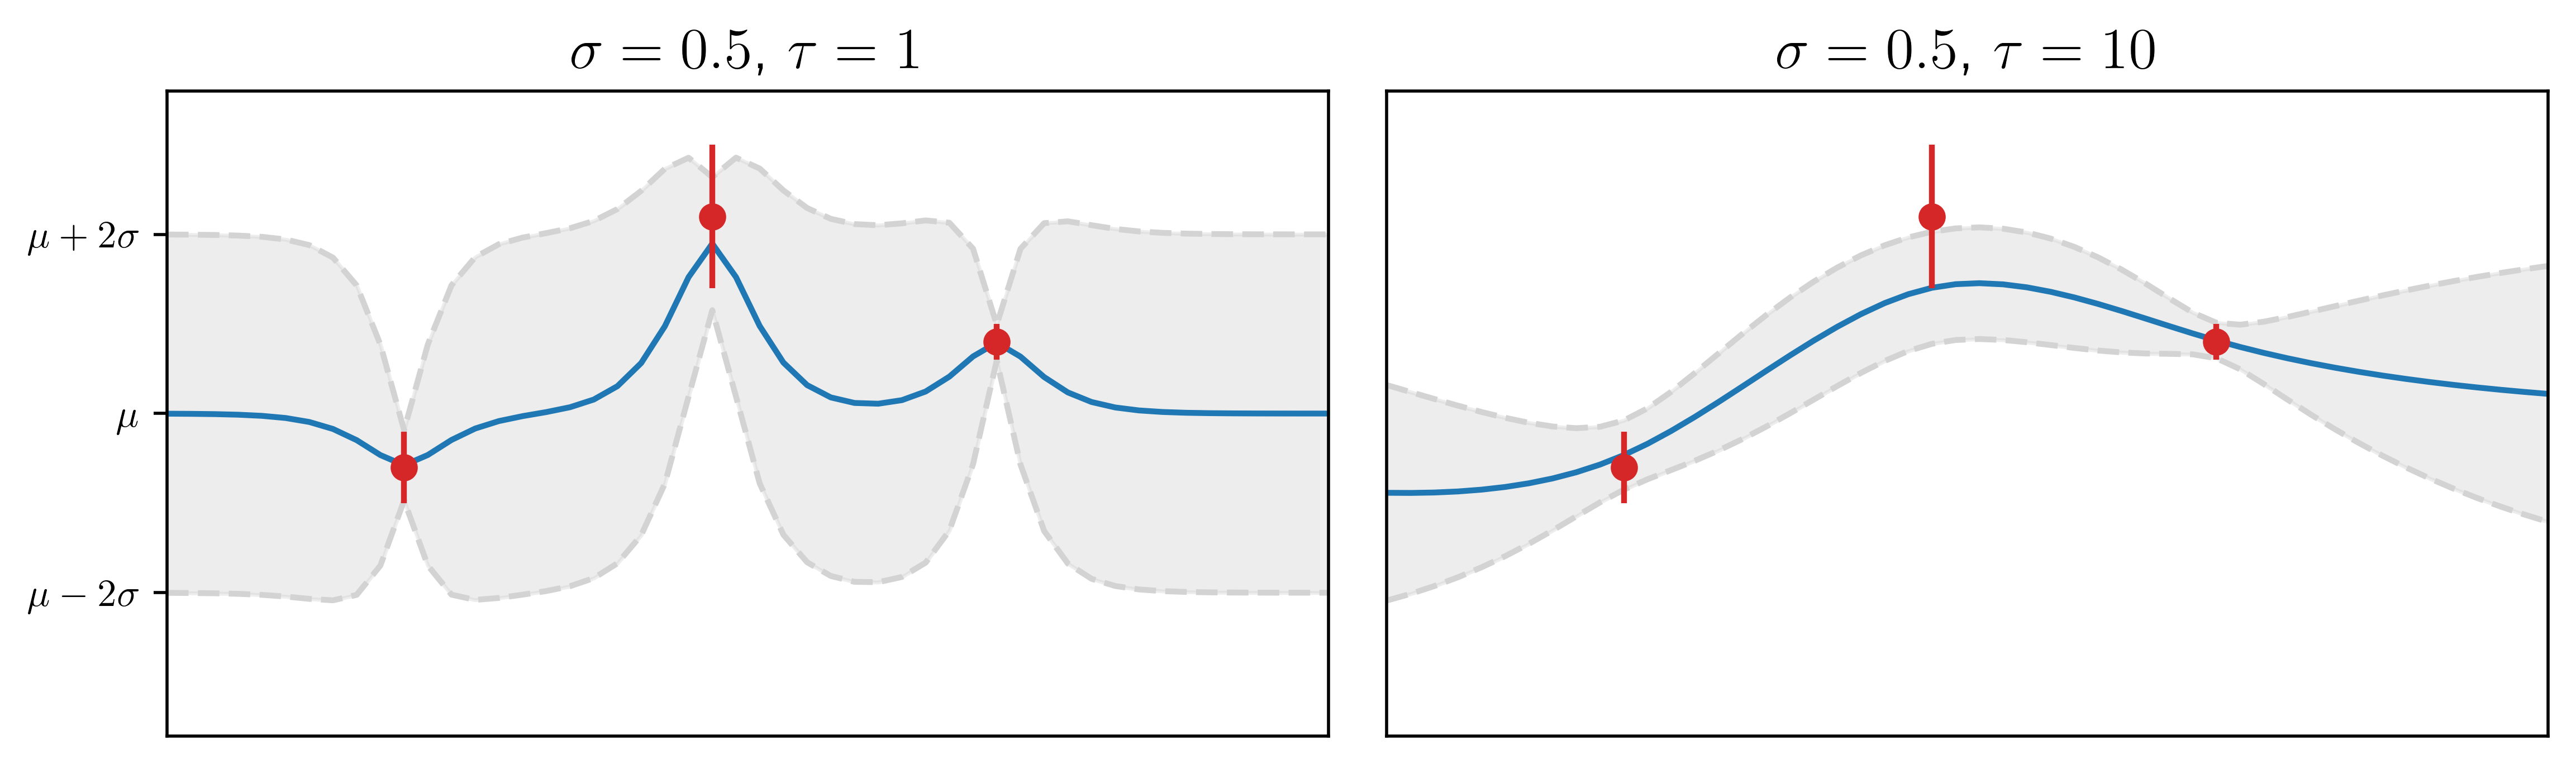

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3), dpi=500)
fig.subplots_adjust(wspace=0.05)
def update(frame):
    for ax, stds, tau, samples, mu in zip(axs, all_stds, all_taus, all_samples, all_mus):
        ax.clear()
        ax.set_title(rf"$\sigma=0.5$, $\tau={tau}$", fontsize=15)
        ax.fill_between(X, mu + 2 * stds, mu - 2 * stds, color="lightgray", alpha=0.4)
        ax.plot(X, mu + 2 * stds, c="lightgray", ls="--")
        ax.plot(X, mu - 2 * stds, c="lightgray", ls="--")
        ax.plot(X, mu, c="C0", zorder=2)
        ax.plot(X, samples[:frame].T, c="C7", alpha=0.2, zorder=1)
        ax.set_xlim(-20, 20)
        ax.set_ylim(-1.8, 1.8)
        ax.set_xticks([])
        ax.errorbar(X_train, Y_train, yerr=2*Y_train_sigma, marker="o", ls="", c="C3", zorder=3)
    axs[0].set_yticks([-2 * sigma, 0, 2 * sigma])
    axs[0].set_yticklabels([r"$\mu - 2\sigma$", r"$\mu$", r"$\mu + 2\sigma$"])
    axs[1].set_yticks([])
ani = animation.FuncAnimation(fig, update, frames=n_samps)
ani.save('../animations/posterior.gif', fps=0.8)

### Optimizing Hyperparameters: Learning the Best Kernel from Data

Up to now, we’ve used fixed kernel parameters (like $\tau$ and $\sigma$) to define our Gaussian Process. But in practice, we usually don’t know the best values for these hyperparameters ahead of time. Instead, we want to **learn** them from the data!

This is where the **marginal likelihood** (also called the evidence) comes in. The marginal likelihood measures how probable the observed data is under the GP model, given a set of kernel parameters. By maximizing this quantity, we can find the hyperparameters that best explain our data.

Mathematically, the (log) marginal likelihood for a GP with kernel parameters $\theta$ is:

$$
\log p(\mathbf{y} \mid X, \theta) = -\frac{1}{2} \mathbf{y}^\top (K + \Sigma_y)^{-1} \mathbf{y}
- \frac{1}{2} \log |K + \Sigma_y| - \frac{n}{2} \log 2\pi
$$

- $K$ is the kernel matrix computed with the current hyperparameters.
- $\Sigma_y$ is the noise covariance.
- $\mathbf{y}$ is the vector of observed outputs.

We typically **minimize the negative log marginal likelihood** (NLL) using numerical optimization. This process automatically tunes the kernel parameters to fit the data as well as possible, balancing model complexity and data fit.

In the next cell, we’ll use `scipy.optimize.minimize` to find the optimal values for $\tau$ and $\sigma$, and then visualize the resulting GP posterior with these learned hyperparameters!

In [10]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, sigma_y, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, tau=theta[0], sigma=theta[1]) + \
            sigma_y**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(np.linalg.inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, tau=theta[0], sigma=theta[1]) + \
            sigma_y**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, Y_train_sigma), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
tau_opt, sigma_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_opt, cov_opt = posterior(X, X_train, Y_train, tau=tau_opt, sigma=sigma_opt, sigma_y=Y_train_sigma)

In [13]:
samples_opt = np.random.multivariate_normal(mu_opt.ravel(), cov_opt, n_samps)
stds_opt = np.sqrt(np.diag(cov_opt))

MovieWriter ffmpeg unavailable; using Pillow instead.


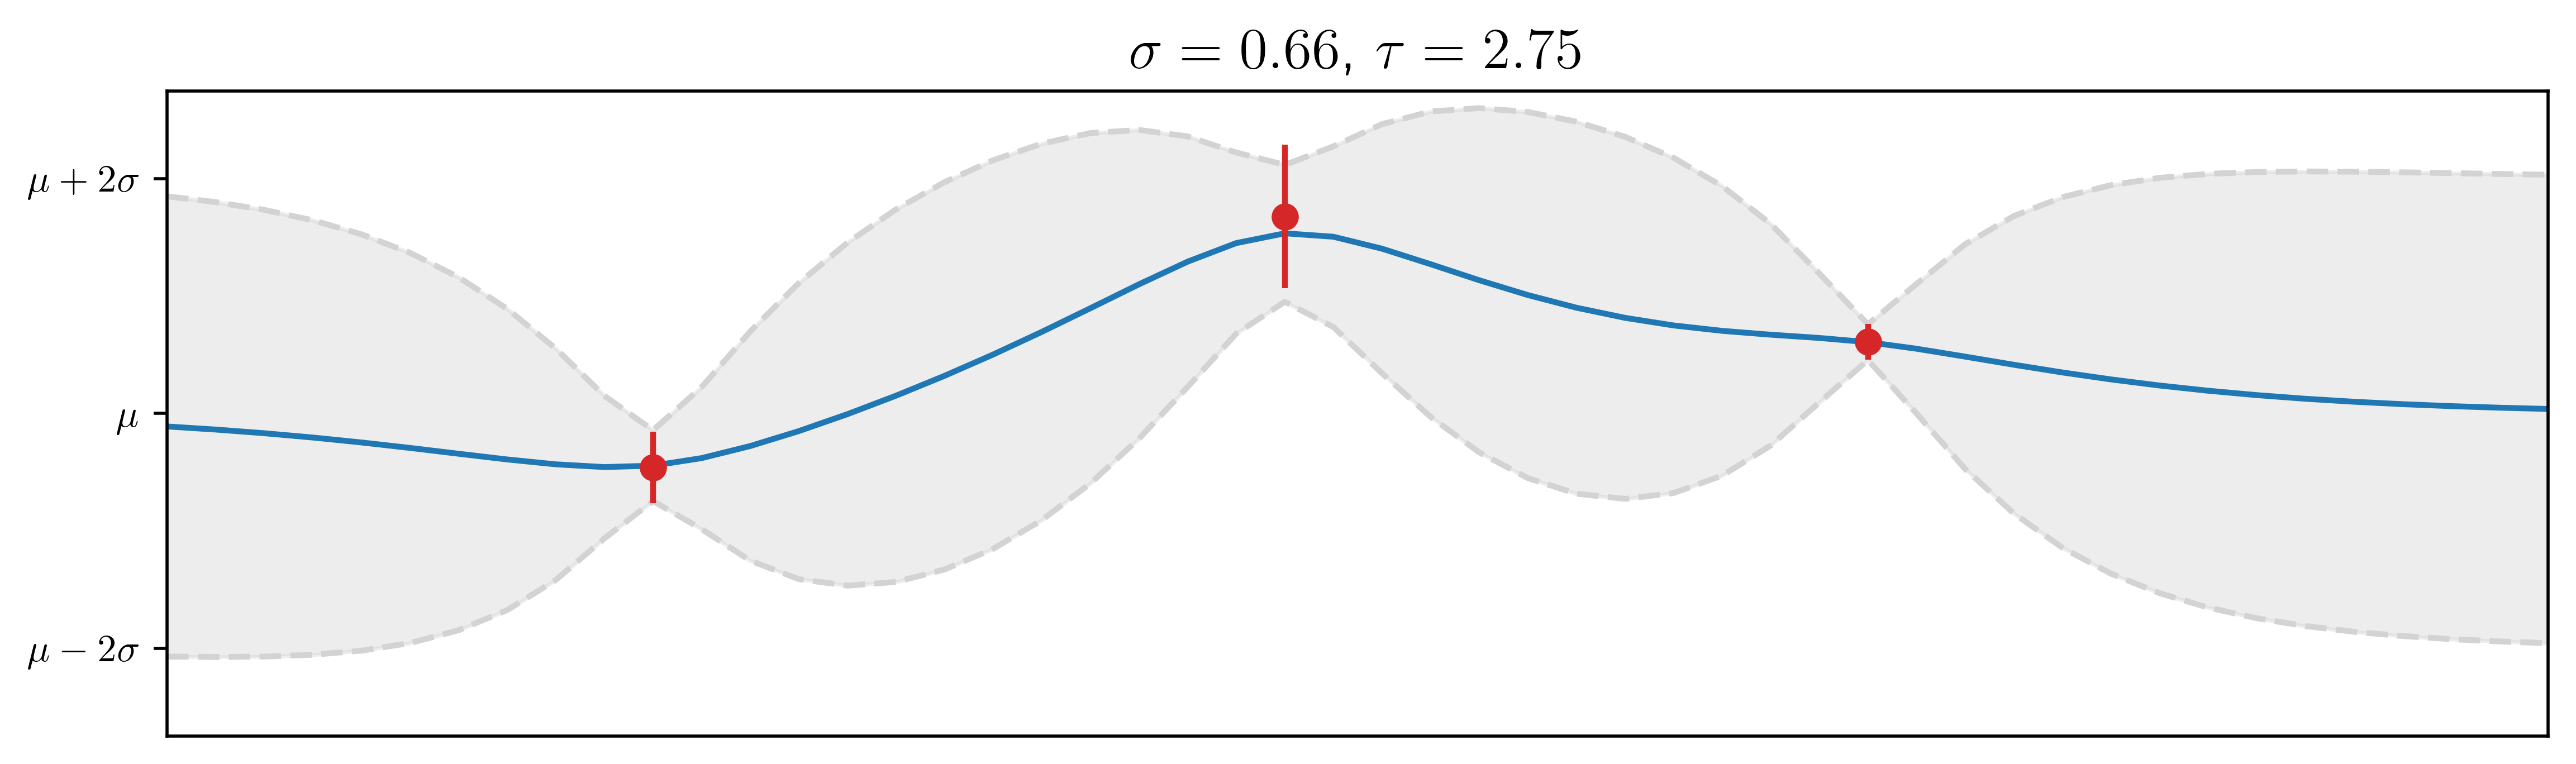

In [17]:
fig, (ax) = plt.subplots(1, 1, figsize=(11, 3), dpi=500)
fig.subplots_adjust(wspace=0.05)
def update(frame):
    ax.clear()
    ax.set_title(rf"$\sigma={sigma_opt:.2f}$, $\tau={tau_opt:.2f}$", fontsize=15)
    ax.fill_between(X, mu_opt + 2 * stds_opt, mu_opt - 2 * stds_opt, color="lightgray", alpha=0.4)
    ax.plot(X, mu_opt + 2 * stds_opt, c="lightgray", ls="--")
    ax.plot(X, mu_opt - 2 * stds_opt, c="lightgray", ls="--")
    ax.plot(X, mu_opt, c="C0", zorder=2)
    ax.plot(X, samples_opt[:frame].T, c="C7", alpha=0.2, zorder=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-1.8, 1.8)
    ax.set_xticks([])
    ax.errorbar(X_train, Y_train, yerr=2*Y_train_sigma, marker="o", ls="", c="C3", zorder=3)
    ax.set_yticks([-2 * sigma_opt, 0, 2 * sigma_opt])
    ax.set_yticklabels([r"$\mu - 2\sigma$", r"$\mu$", r"$\mu + 2\sigma$"])
# ax_placeholder.set_xticks([])
# ax_placeholder.set_yticks([])
ani = animation.FuncAnimation(fig, update, frames=n_samps)
ani.save('../animations/posterior_opt.gif', fps=0.8)